# Experiment with Additional ML Models for Viral Load Suppression Prediction
## Testing 3 Different Models: Random Forest, XGBoost, and SVM
### Goal: Compare these models across all preprocessing strategies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.metrics import (
    roc_auc_score, average_precision_score, recall_score,
    precision_recall_curve, roc_curve, classification_report,
    confusion_matrix, f1_score, accuracy_score
)
from sklearn.model_selection import cross_val_score
import pickle
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

## 1. Load Preprocessed Data
We'll test each model on all 4 preprocessing strategies:
- Strategy 1: Simple (Median/Mode)
- Strategy 2a: KNN Imputation
- Strategy 2b: MICE Imputation
- Strategy 3: Domain-Informed

In [2]:
def load_data(strategy_name, strategy_prefix):
    """Load training and test data for a given preprocessing strategy"""
    X_train = pd.read_csv(f'preprocessed_data/{strategy_prefix}_X_train.csv')
    X_test = pd.read_csv(f'preprocessed_data/{strategy_prefix}_X_test.csv')
    
    # Determine y file prefix (strategy2a and strategy2b share strategy2 y files)
    if strategy_prefix.startswith('strategy2'):
        y_prefix = 'strategy2'
    else:
        y_prefix = strategy_prefix
    
    # Load target variables and handle conversion properly
    y_train_df = pd.read_csv(f'preprocessed_data/{y_prefix}_y_train.csv')
    y_test_df = pd.read_csv(f'preprocessed_data/{y_prefix}_y_test.csv')
    
    # Convert to numpy array, flatten, and safely convert to int
    y_train = y_train_df.values.ravel()
    y_test = y_test_df.values.ravel()
    
    # Handle any NaN values and convert to int
    y_train = np.nan_to_num(y_train, nan=0).astype(np.int32)
    y_test = np.nan_to_num(y_test, nan=0).astype(np.int32)
    
    print(f"{strategy_name}:")
    print(f"  Training: {X_train.shape}, Test: {X_test.shape}")
    print(f"  Class distribution (train): {np.bincount(y_train)}")
    print(f"  Class distribution (test): {np.bincount(y_test)}")
    
    return X_train, X_test, y_train, y_test

# Load all preprocessing strategies
strategies = {
    'Simple (Median/Mode)': 'strategy1',
    'KNN Imputation': 'strategy2a_knn',
    'MICE Imputation': 'strategy2b_mice',
    'Domain-Informed': 'strategy3_domain'
}

datasets = {}
for name, prefix in strategies.items():
    datasets[name] = load_data(name, prefix)
    print()

Simple (Median/Mode):
  Training: (26408, 32), Test: (6603, 32)
  Class distribution (train): [17557  8851]
  Class distribution (test): [4390 2213]

KNN Imputation:
  Training: (26408, 32), Test: (6603, 32)
  Class distribution (train): [17557  8851]
  Class distribution (test): [4390 2213]

MICE Imputation:
  Training: (26408, 32), Test: (6603, 32)
  Class distribution (train): [17557  8851]
  Class distribution (test): [4390 2213]



Domain-Informed:
  Training: (26408, 43), Test: (6603, 43)
  Class distribution (train): [17557  8851]
  Class distribution (test): [4390 2213]



## 2. Define Evaluation Function

In [3]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name, strategy_name):
    """Train and evaluate a model with comprehensive metrics"""
    
    print(f"\n{'='*80}")
    print(f"Training {model_name} with {strategy_name}")
    print(f"{'='*80}")
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Get predictions and probabilities
    y_pred = model.predict(X_test)
    
    # Handle probability predictions (SVM might not have predict_proba with all kernels)
    if hasattr(model, 'predict_proba'):
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, 'decision_function'):
        # For SVM with decision_function
        decision_scores = model.decision_function(X_test)
        # Normalize to 0-1 range for consistency
        y_pred_proba = (decision_scores - decision_scores.min()) / (decision_scores.max() - decision_scores.min())
    else:
        y_pred_proba = y_pred  # Fallback
    
    # Calculate metrics
    auroc = roc_auc_score(y_test, y_pred_proba)
    pr_auc = average_precision_score(y_test, y_pred_proba)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    recall_default = recall_score(y_test, y_pred)
    
    # Calculate recall at different thresholds
    recall_03 = recall_score(y_test, (y_pred_proba >= 0.3).astype(int))
    recall_05 = recall_score(y_test, (y_pred_proba >= 0.5).astype(int))
    recall_07 = recall_score(y_test, (y_pred_proba >= 0.7).astype(int))
    
    # Print results
    print(f"\nPerformance Metrics:")
    print(f"  AUROC: {auroc:.6f}")
    print(f"  PR AUC: {pr_auc:.6f}")
    print(f"  Accuracy: {accuracy:.6f}")
    print(f"  F1 Score: {f1:.6f}")
    print(f"  Recall (default threshold): {recall_default:.6f}")
    print(f"  Recall @0.3: {recall_03:.6f}")
    print(f"  Recall @0.5: {recall_05:.6f}")
    print(f"  Recall @0.7: {recall_07:.6f}")
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"\nConfusion Matrix:")
    print(cm)
    
    # Store results
    results = {
        'Model': model_name,
        'Strategy': strategy_name,
        'AUROC': auroc,
        'PR AUC': pr_auc,
        'Accuracy': accuracy,
        'F1 Score': f1,
        'Recall (default)': recall_default,
        'Recall @0.3': recall_03,
        'Recall @0.5': recall_05,
        'Recall @0.7': recall_07
    }
    
    return results, y_pred_proba, model

## 3. Model 1: Random Forest Classifier
Random Forest is an ensemble method that creates multiple decision trees and aggregates their predictions.

In [4]:
print("\n" + "#"*80)
print("# RANDOM FOREST CLASSIFIER")
print("#"*80)

rf_results = []
rf_models = {}
rf_predictions = {}

for strategy_name, (X_train, X_test, y_train, y_test) in datasets.items():
    # Initialize Random Forest with optimized hyperparameters
    rf_model = RandomForestClassifier(
        n_estimators=200,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        max_features='sqrt',
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
    
    results, y_pred_proba, trained_model = evaluate_model(
        rf_model, X_train, X_test, y_train, y_test,
        'Random Forest', strategy_name
    )
    
    rf_results.append(results)
    rf_models[strategy_name] = trained_model
    rf_predictions[strategy_name] = y_pred_proba

# Create results dataframe
rf_results_df = pd.DataFrame(rf_results)
print("\n" + "="*80)
print("RANDOM FOREST SUMMARY")
print("="*80)
print(rf_results_df.to_string(index=False))


################################################################################
# RANDOM FOREST CLASSIFIER
################################################################################

Training Random Forest with Simple (Median/Mode)



Performance Metrics:
  AUROC: 0.999942
  PR AUC: 0.999883
  Accuracy: 0.993033
  F1 Score: 0.989714
  Recall (default threshold): 1.000000
  Recall @0.3: 1.000000
  Recall @0.5: 1.000000
  Recall @0.7: 0.996385

Confusion Matrix:
[[4344   46]
 [   0 2213]]

Training Random Forest with KNN Imputation



Performance Metrics:
  AUROC: 0.999009
  PR AUC: 0.997541
  Accuracy: 0.991368
  F1 Score: 0.987285
  Recall (default threshold): 1.000000
  Recall @0.3: 1.000000
  Recall @0.5: 1.000000
  Recall @0.7: 0.995029

Confusion Matrix:
[[4333   57]
 [   0 2213]]

Training Random Forest with MICE Imputation



Performance Metrics:
  AUROC: 0.999819
  PR AUC: 0.999619
  Accuracy: 0.990913
  F1 Score: 0.986625
  Recall (default threshold): 1.000000
  Recall @0.3: 1.000000
  Recall @0.5: 1.000000
  Recall @0.7: 0.992770

Confusion Matrix:
[[4330   60]
 [   0 2213]]

Training Random Forest with Domain-Informed



Performance Metrics:
  AUROC: 0.999999
  PR AUC: 0.999998
  Accuracy: 0.995457
  F1 Score: 0.993268
  Recall (default threshold): 1.000000
  Recall @0.3: 1.000000
  Recall @0.5: 1.000000
  Recall @0.7: 0.999548

Confusion Matrix:
[[4360   30]
 [   0 2213]]

RANDOM FOREST SUMMARY
        Model             Strategy    AUROC   PR AUC  Accuracy  F1 Score  Recall (default)  Recall @0.3  Recall @0.5  Recall @0.7
Random Forest Simple (Median/Mode) 0.999942 0.999883  0.993033  0.989714               1.0          1.0          1.0     0.996385
Random Forest       KNN Imputation 0.999009 0.997541  0.991368  0.987285               1.0          1.0          1.0     0.995029
Random Forest      MICE Imputation 0.999819 0.999619  0.990913  0.986625               1.0          1.0          1.0     0.992770
Random Forest      Domain-Informed 0.999999 0.999998  0.995457  0.993268               1.0          1.0          1.0     0.999548


## 4. Model 2: XGBoost Classifier
XGBoost is a gradient boosting framework known for high performance and speed.

In [5]:
print("\n" + "#"*80)
print("# XGBOOST CLASSIFIER")
print("#"*80)

xgb_results = []
xgb_models = {}
xgb_predictions = {}

for strategy_name, (X_train, X_test, y_train, y_test) in datasets.items():
    # Calculate scale_pos_weight for imbalanced classes
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
    
    # Initialize XGBoost with optimized hyperparameters
    xgb_model = xgb.XGBClassifier(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=scale_pos_weight,
        random_state=42,
        eval_metric='logloss',
        use_label_encoder=False
    )
    
    results, y_pred_proba, trained_model = evaluate_model(
        xgb_model, X_train, X_test, y_train, y_test,
        'XGBoost', strategy_name
    )
    
    xgb_results.append(results)
    xgb_models[strategy_name] = trained_model
    xgb_predictions[strategy_name] = y_pred_proba

# Create results dataframe
xgb_results_df = pd.DataFrame(xgb_results)
print("\n" + "="*80)
print("XGBOOST SUMMARY")
print("="*80)
print(xgb_results_df.to_string(index=False))


################################################################################
# XGBOOST CLASSIFIER
################################################################################

Training XGBoost with Simple (Median/Mode)



Performance Metrics:
  AUROC: 0.997186
  PR AUC: 0.991765
  Accuracy: 0.993791
  F1 Score: 0.990817
  Recall (default threshold): 0.999548
  Recall @0.3: 1.000000
  Recall @0.5: 0.999548
  Recall @0.7: 0.999548

Confusion Matrix:
[[4350   40]
 [   1 2212]]

Training XGBoost with KNN Imputation



Performance Metrics:
  AUROC: 0.997231
  PR AUC: 0.992466
  Accuracy: 0.991216
  F1 Score: 0.987065
  Recall (default threshold): 1.000000
  Recall @0.3: 1.000000
  Recall @0.5: 1.000000
  Recall @0.7: 0.999548

Confusion Matrix:
[[4332   58]
 [   0 2213]]

Training XGBoost with MICE Imputation



Performance Metrics:
  AUROC: 0.997280
  PR AUC: 0.990215
  Accuracy: 0.995305
  F1 Score: 0.993045
  Recall (default threshold): 1.000000
  Recall @0.3: 1.000000
  Recall @0.5: 1.000000
  Recall @0.7: 1.000000

Confusion Matrix:
[[4359   31]
 [   0 2213]]

Training XGBoost with Domain-Informed



Performance Metrics:
  AUROC: 0.997038
  PR AUC: 0.991007
  Accuracy: 0.994245
  F1 Score: 0.991487
  Recall (default threshold): 1.000000
  Recall @0.3: 1.000000
  Recall @0.5: 1.000000
  Recall @0.7: 0.999548

Confusion Matrix:
[[4352   38]
 [   0 2213]]

XGBOOST SUMMARY
  Model             Strategy    AUROC   PR AUC  Accuracy  F1 Score  Recall (default)  Recall @0.3  Recall @0.5  Recall @0.7
XGBoost Simple (Median/Mode) 0.997186 0.991765  0.993791  0.990817          0.999548          1.0     0.999548     0.999548
XGBoost       KNN Imputation 0.997231 0.992466  0.991216  0.987065          1.000000          1.0     1.000000     0.999548
XGBoost      MICE Imputation 0.997280 0.990215  0.995305  0.993045          1.000000          1.0     1.000000     1.000000
XGBoost      Domain-Informed 0.997038 0.991007  0.994245  0.991487          1.000000          1.0     1.000000     0.999548


## 5. Model 3: Support Vector Machine (SVM)
SVM finds the optimal hyperplane that maximizes the margin between classes.

In [6]:
print("\n" + "#"*80)
print("# SUPPORT VECTOR MACHINE (SVM)")
print("#"*80)

svm_results = []
svm_models = {}
svm_predictions = {}

for strategy_name, (X_train, X_test, y_train, y_test) in datasets.items():
    # Initialize SVM with RBF kernel and probability estimates
    svm_model = SVC(
        kernel='rbf',
        C=1.0,
        gamma='scale',
        class_weight='balanced',
        probability=True,  # Enable probability estimates
        random_state=42
    )
    
    results, y_pred_proba, trained_model = evaluate_model(
        svm_model, X_train, X_test, y_train, y_test,
        'SVM (RBF)', strategy_name
    )
    
    svm_results.append(results)
    svm_models[strategy_name] = trained_model
    svm_predictions[strategy_name] = y_pred_proba

# Create results dataframe
svm_results_df = pd.DataFrame(svm_results)
print("\n" + "="*80)
print("SVM SUMMARY")
print("="*80)
print(svm_results_df.to_string(index=False))


################################################################################
# SUPPORT VECTOR MACHINE (SVM)
################################################################################

Training SVM (RBF) with Simple (Median/Mode)



Performance Metrics:
  AUROC: 0.981553
  PR AUC: 0.936482
  Accuracy: 0.936241
  F1 Score: 0.912818
  Recall (default threshold): 0.995933
  Recall @0.3: 0.992770
  Recall @0.5: 0.986444
  Recall @0.7: 0.938545

Confusion Matrix:
[[3978  412]
 [   9 2204]]

Training SVM (RBF) with KNN Imputation



Performance Metrics:
  AUROC: 0.980551
  PR AUC: 0.928912
  Accuracy: 0.930638
  F1 Score: 0.905993
  Recall (default threshold): 0.997289
  Recall @0.3: 0.991866
  Recall @0.5: 0.982829
  Recall @0.7: 0.931767

Confusion Matrix:
[[3938  452]
 [   6 2207]]

Training SVM (RBF) with MICE Imputation



Performance Metrics:
  AUROC: 0.980401
  PR AUC: 0.923171
  Accuracy: 0.934272
  F1 Score: 0.910589
  Recall (default threshold): 0.998644
  Recall @0.3: 0.993222
  Recall @0.5: 0.986444
  Recall @0.7: 0.939449

Confusion Matrix:
[[3959  431]
 [   3 2210]]

Training SVM (RBF) with Domain-Informed



Performance Metrics:
  AUROC: 0.989820
  PR AUC: 0.966027
  Accuracy: 0.934575
  F1 Score: 0.910744
  Recall (default threshold): 0.995933
  Recall @0.3: 0.986896
  Recall @0.5: 0.979666
  Recall @0.7: 0.957524

Confusion Matrix:
[[3967  423]
 [   9 2204]]

SVM SUMMARY
    Model             Strategy    AUROC   PR AUC  Accuracy  F1 Score  Recall (default)  Recall @0.3  Recall @0.5  Recall @0.7
SVM (RBF) Simple (Median/Mode) 0.981553 0.936482  0.936241  0.912818          0.995933     0.992770     0.986444     0.938545
SVM (RBF)       KNN Imputation 0.980551 0.928912  0.930638  0.905993          0.997289     0.991866     0.982829     0.931767
SVM (RBF)      MICE Imputation 0.980401 0.923171  0.934272  0.910589          0.998644     0.993222     0.986444     0.939449
SVM (RBF)      Domain-Informed 0.989820 0.966027  0.934575  0.910744          0.995933     0.986896     0.979666     0.957524


## 6. Comprehensive Comparison of All 3 Models

In [7]:
# Combine all results
all_results = pd.concat([
    rf_results_df,
    xgb_results_df,
    svm_results_df
], ignore_index=True)

print("\n" + "="*100)
print("COMPREHENSIVE COMPARISON - ALL 3 NEW MODELS")
print("="*100)
print(all_results.to_string(index=False))
print("\n" + "="*100)


COMPREHENSIVE COMPARISON - ALL 3 NEW MODELS
        Model             Strategy    AUROC   PR AUC  Accuracy  F1 Score  Recall (default)  Recall @0.3  Recall @0.5  Recall @0.7
Random Forest Simple (Median/Mode) 0.999942 0.999883  0.993033  0.989714          1.000000     1.000000     1.000000     0.996385
Random Forest       KNN Imputation 0.999009 0.997541  0.991368  0.987285          1.000000     1.000000     1.000000     0.995029
Random Forest      MICE Imputation 0.999819 0.999619  0.990913  0.986625          1.000000     1.000000     1.000000     0.992770
Random Forest      Domain-Informed 0.999999 0.999998  0.995457  0.993268          1.000000     1.000000     1.000000     0.999548
      XGBoost Simple (Median/Mode) 0.997186 0.991765  0.993791  0.990817          0.999548     1.000000     0.999548     0.999548
      XGBoost       KNN Imputation 0.997231 0.992466  0.991216  0.987065          1.000000     1.000000     1.000000     0.999548
      XGBoost      MICE Imputation 0.997280 0

## 7. Visualization: AUROC Comparison

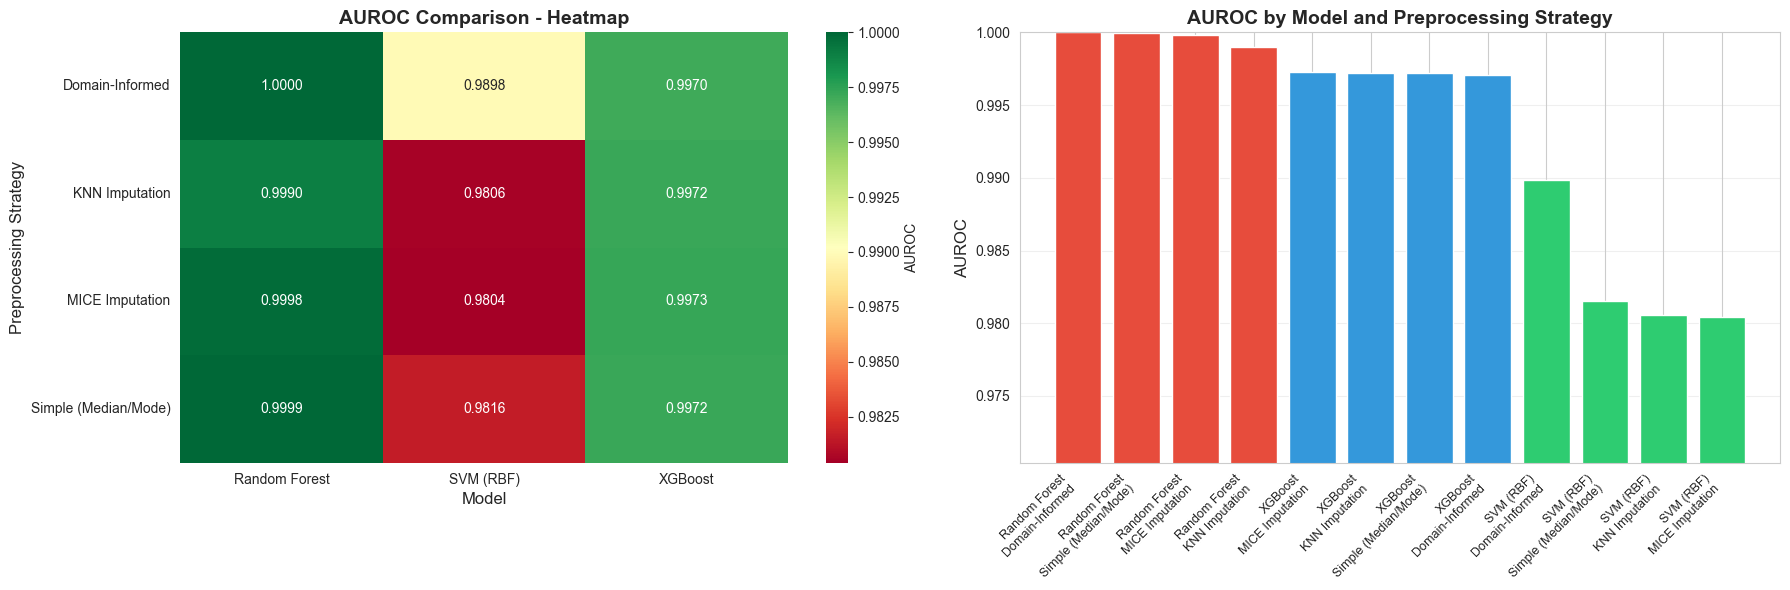

In [8]:
# AUROC Comparison
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Heatmap
auroc_pivot = all_results.pivot(index='Strategy', columns='Model', values='AUROC')
sns.heatmap(auroc_pivot, annot=True, fmt='.4f', cmap='RdYlGn',
            vmin=auroc_pivot.min().min(), vmax=1.0,
            ax=axes[0], cbar_kws={'label': 'AUROC'})
axes[0].set_title('AUROC Comparison - Heatmap', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Model', fontsize=12)
axes[0].set_ylabel('Preprocessing Strategy', fontsize=12)

# Bar plot
all_results_sorted = all_results.sort_values('AUROC', ascending=False)
x_labels = [f"{row['Model']}\n{row['Strategy']}" for _, row in all_results_sorted.iterrows()]
colors = ['#e74c3c' if 'Random' in label else '#3498db' if 'XGBoost' in label else '#2ecc71' 
          for label in x_labels]

axes[1].bar(range(len(all_results_sorted)), all_results_sorted['AUROC'], color=colors)
axes[1].set_xticks(range(len(all_results_sorted)))
axes[1].set_xticklabels(x_labels, rotation=45, ha='right', fontsize=9)
axes[1].set_ylabel('AUROC', fontsize=12)
axes[1].set_title('AUROC by Model and Preprocessing Strategy', fontsize=14, fontweight='bold')
axes[1].set_ylim([all_results_sorted['AUROC'].min() - 0.01, 1.0])
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('experiment_auroc_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 8. Visualization: PR AUC Comparison

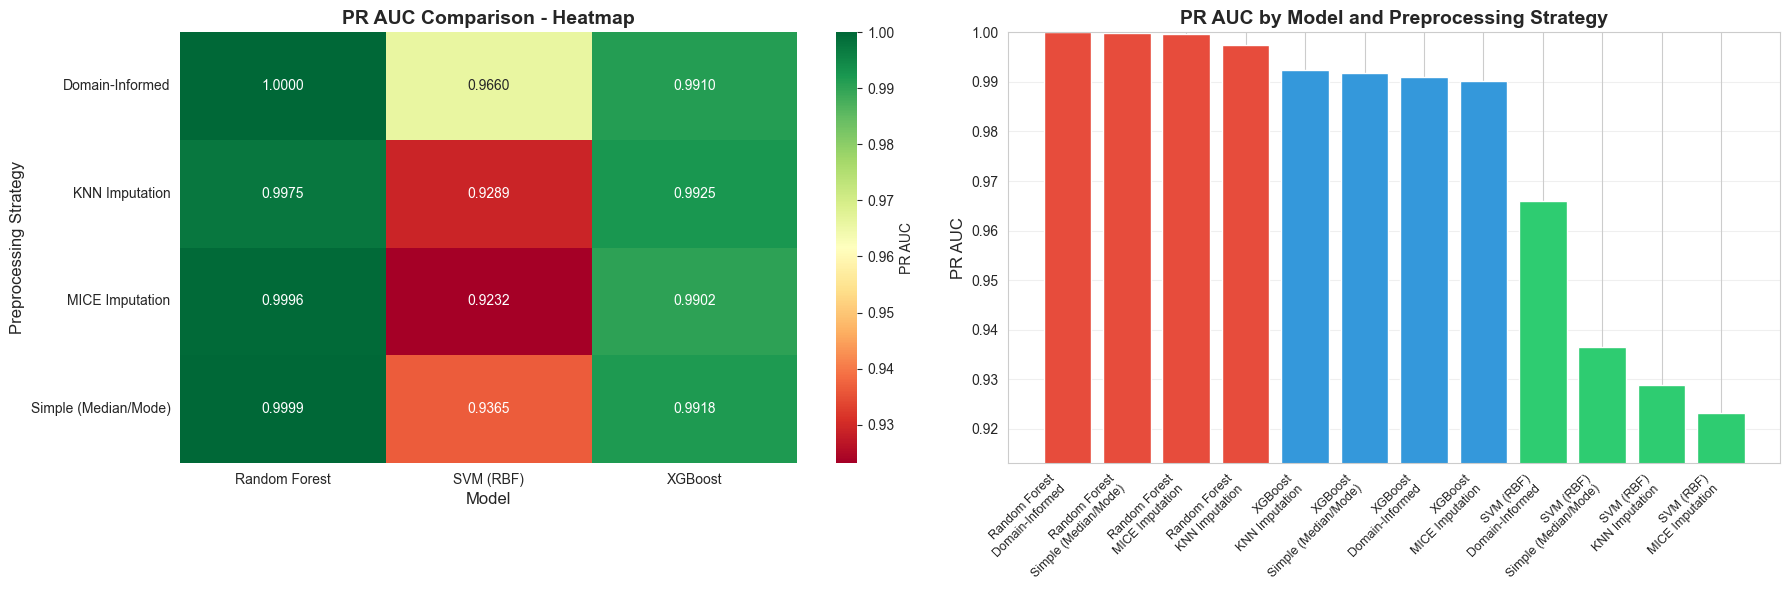

In [9]:
# PR AUC Comparison
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Heatmap
pr_auc_pivot = all_results.pivot(index='Strategy', columns='Model', values='PR AUC')
sns.heatmap(pr_auc_pivot, annot=True, fmt='.4f', cmap='RdYlGn',
            vmin=pr_auc_pivot.min().min(), vmax=1.0,
            ax=axes[0], cbar_kws={'label': 'PR AUC'})
axes[0].set_title('PR AUC Comparison - Heatmap', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Model', fontsize=12)
axes[0].set_ylabel('Preprocessing Strategy', fontsize=12)

# Bar plot
all_results_sorted = all_results.sort_values('PR AUC', ascending=False)
x_labels = [f"{row['Model']}\n{row['Strategy']}" for _, row in all_results_sorted.iterrows()]
colors = ['#e74c3c' if 'Random' in label else '#3498db' if 'XGBoost' in label else '#2ecc71' 
          for label in x_labels]

axes[1].bar(range(len(all_results_sorted)), all_results_sorted['PR AUC'], color=colors)
axes[1].set_xticks(range(len(all_results_sorted)))
axes[1].set_xticklabels(x_labels, rotation=45, ha='right', fontsize=9)
axes[1].set_ylabel('PR AUC', fontsize=12)
axes[1].set_title('PR AUC by Model and Preprocessing Strategy', fontsize=14, fontweight='bold')
axes[1].set_ylim([all_results_sorted['PR AUC'].min() - 0.01, 1.0])
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('experiment_pr_auc_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 9. Visualization: Multi-Metric Radar Chart

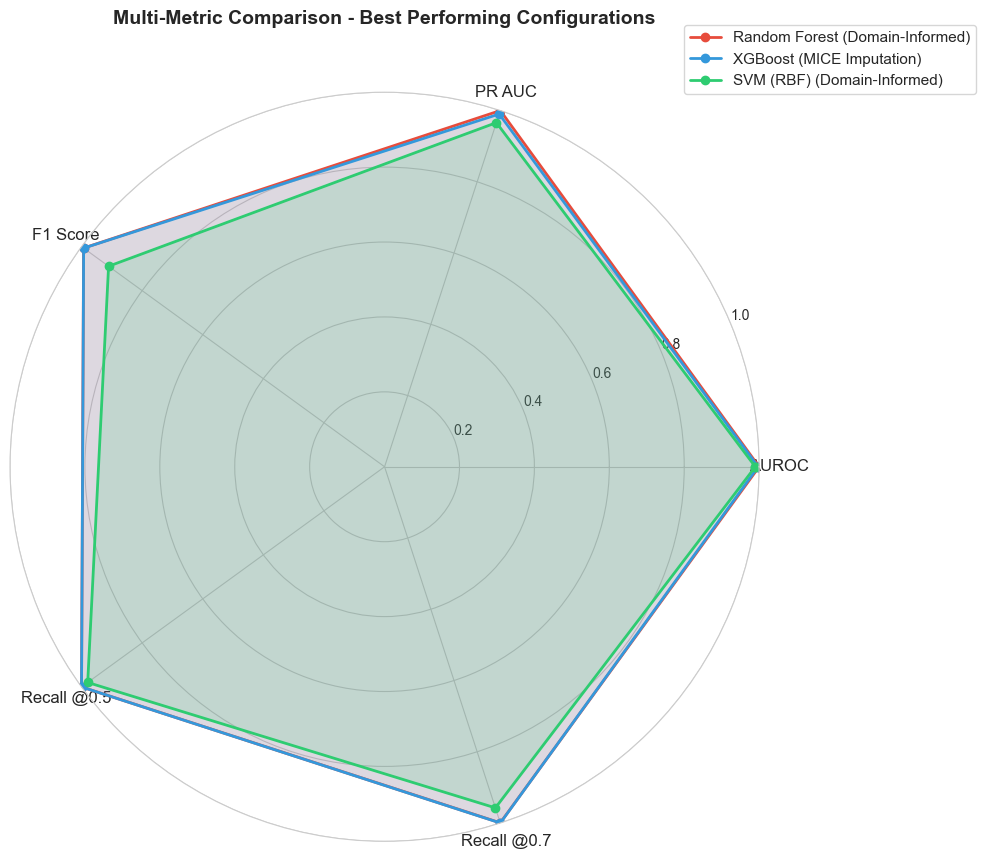

In [10]:
from math import pi

# Select best combination for each model
best_rf = all_results[all_results['Model'] == 'Random Forest'].nlargest(1, 'AUROC').iloc[0]
best_xgb = all_results[all_results['Model'] == 'XGBoost'].nlargest(1, 'AUROC').iloc[0]
best_svm = all_results[all_results['Model'] == 'SVM (RBF)'].nlargest(1, 'AUROC').iloc[0]

# Create radar chart
categories = ['AUROC', 'PR AUC', 'F1 Score', 'Recall @0.5', 'Recall @0.7']
N = len(categories)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

# Plot for each model
models_to_plot = [
    (best_rf, 'Random Forest', '#e74c3c'),
    (best_xgb, 'XGBoost', '#3498db'),
    (best_svm, 'SVM (RBF)', '#2ecc71')
]

for model_data, model_name, color in models_to_plot:
    values = [model_data[cat] for cat in categories]
    values += values[:1]
    
    ax.plot(angles, values, 'o-', linewidth=2, 
            label=f"{model_name} ({model_data['Strategy']})", color=color)
    ax.fill(angles, values, alpha=0.15, color=color)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, size=12)
ax.set_ylim(0, 1)
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], size=10)
ax.grid(True)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=11)
ax.set_title('Multi-Metric Comparison - Best Performing Configurations', 
             size=14, fontweight='bold', y=1.08)

plt.tight_layout()
plt.savefig('experiment_radar_chart.png', dpi=300, bbox_inches='tight')
plt.show()

## 10. Model Performance by Preprocessing Strategy


AVERAGE PERFORMANCE BY PREPROCESSING STRATEGY
                         AUROC    PR AUC  F1 Score  Recall @0.5
Strategy                                                       
Domain-Informed       0.995619  0.985677  0.965166     0.993222
KNN Imputation        0.992264  0.972973  0.960115     0.994276
MICE Imputation       0.992500  0.971002  0.963420     0.995481
Simple (Median/Mode)  0.992894  0.976043  0.964450     0.995331


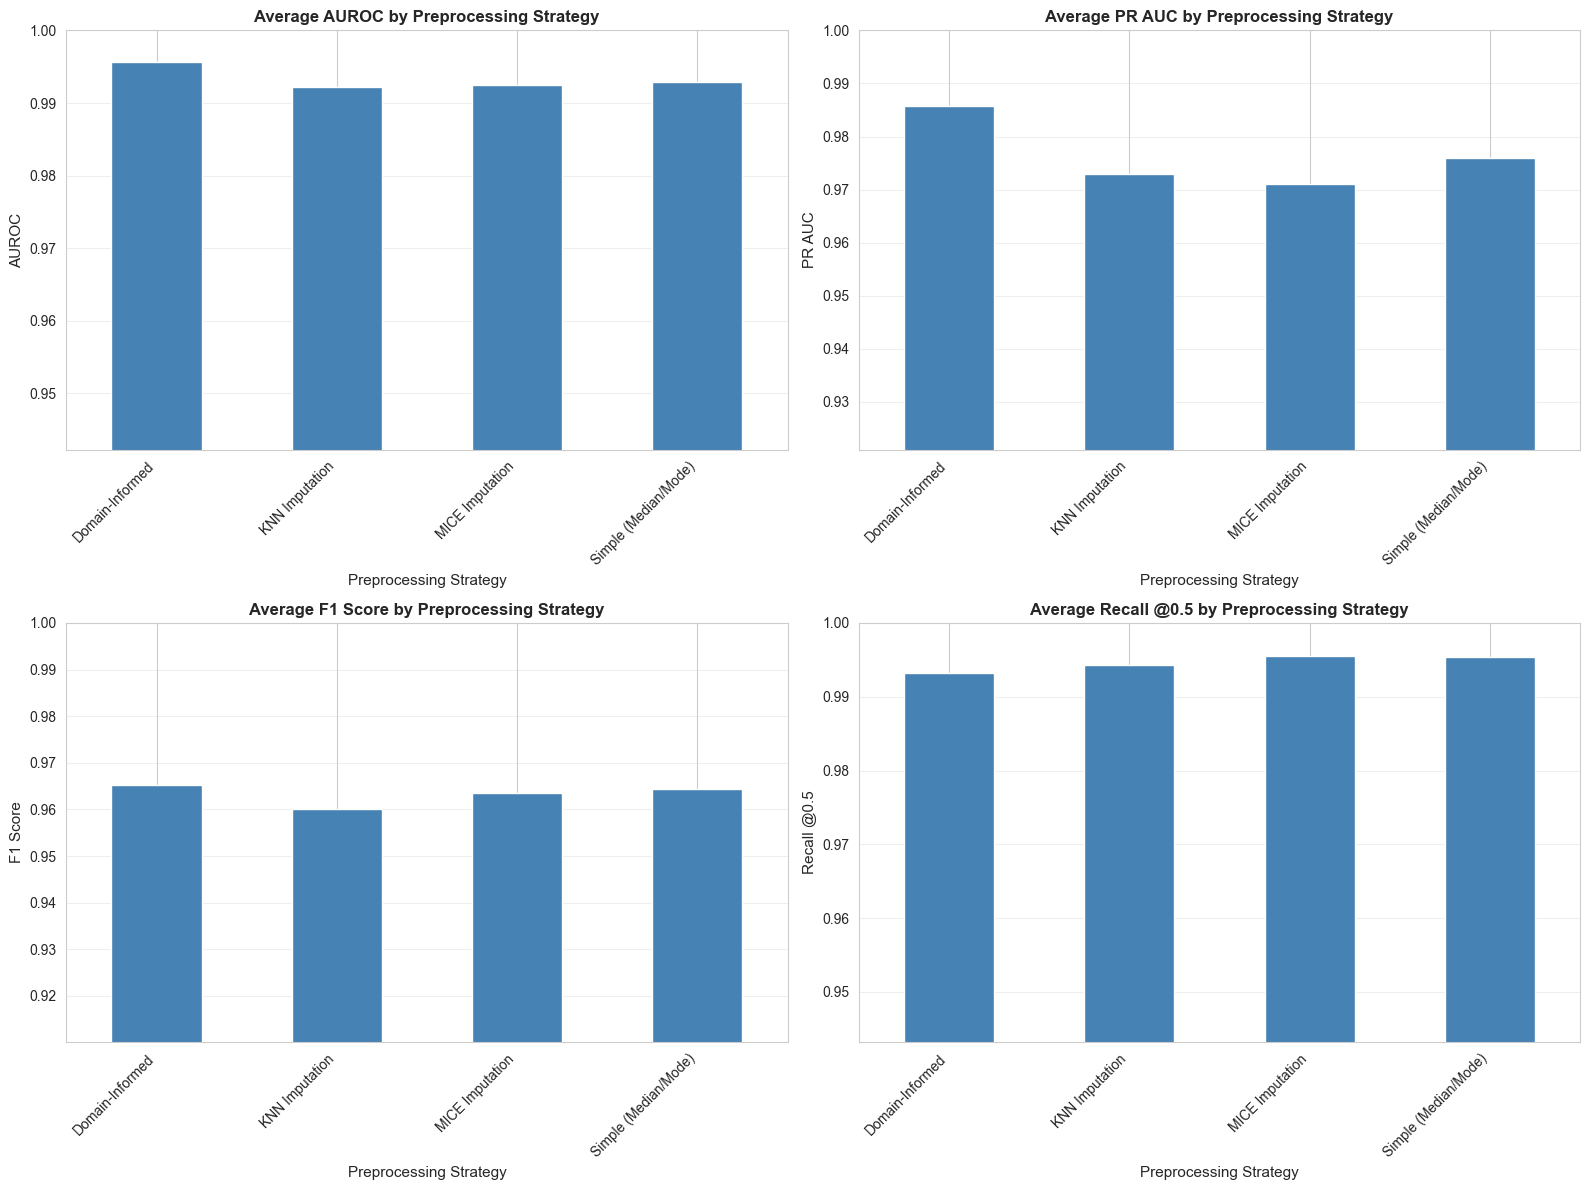

In [11]:
# Average performance by preprocessing strategy
strategy_avg = all_results.groupby('Strategy')[['AUROC', 'PR AUC', 'F1 Score', 'Recall @0.5']].mean()

print("\n" + "="*80)
print("AVERAGE PERFORMANCE BY PREPROCESSING STRATEGY")
print("="*80)
print(strategy_avg.to_string())
print("="*80)

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

metrics = ['AUROC', 'PR AUC', 'F1 Score', 'Recall @0.5']
for idx, metric in enumerate(metrics):
    strategy_avg[metric].plot(kind='bar', ax=axes[idx], color='steelblue')
    axes[idx].set_title(f'Average {metric} by Preprocessing Strategy', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Preprocessing Strategy', fontsize=11)
    axes[idx].set_ylabel(metric, fontsize=11)
    axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=45, ha='right')
    axes[idx].grid(axis='y', alpha=0.3)
    axes[idx].set_ylim([strategy_avg[metric].min() - 0.05, 1.0])

plt.tight_layout()
plt.savefig('experiment_by_strategy.png', dpi=300, bbox_inches='tight')
plt.show()

## 11. Model Performance Comparison (average across strategies)


AVERAGE PERFORMANCE BY MODEL
                  AUROC    PR AUC  F1 Score  Recall @0.5
Model                                                   
Random Forest  0.999692  0.999260  0.989223     1.000000
SVM (RBF)      0.983081  0.938648  0.910036     0.983845
XGBoost        0.997184  0.991363  0.990604     0.999887


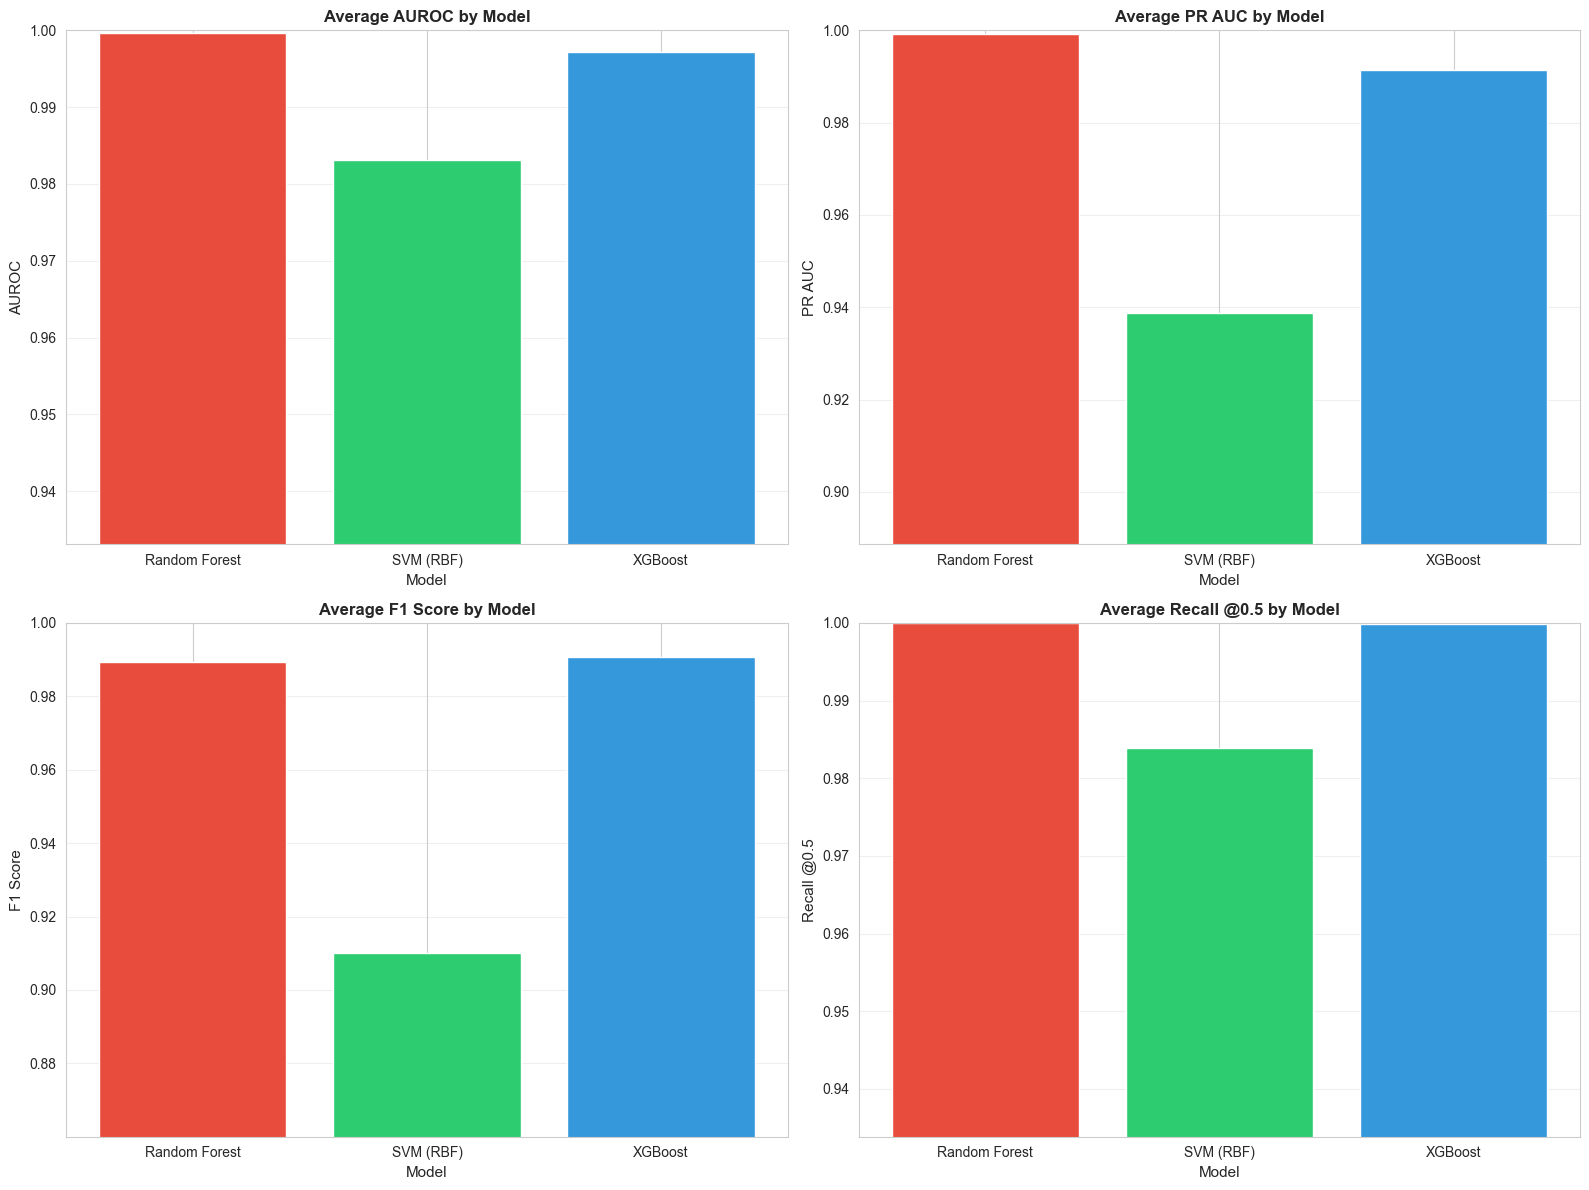

In [12]:
# Average performance by model
model_avg = all_results.groupby('Model')[['AUROC', 'PR AUC', 'F1 Score', 'Recall @0.5']].mean()

print("\n" + "="*80)
print("AVERAGE PERFORMANCE BY MODEL")
print("="*80)
print(model_avg.to_string())
print("="*80)

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

colors_by_model = {'Random Forest': '#e74c3c', 'XGBoost': '#3498db', 'SVM (RBF)': '#2ecc71'}

for idx, metric in enumerate(metrics):
    bars = axes[idx].bar(range(len(model_avg)), model_avg[metric], 
                         color=[colors_by_model[m] for m in model_avg.index])
    axes[idx].set_title(f'Average {metric} by Model', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Model', fontsize=11)
    axes[idx].set_ylabel(metric, fontsize=11)
    axes[idx].set_xticks(range(len(model_avg)))
    axes[idx].set_xticklabels(model_avg.index, rotation=0)
    axes[idx].grid(axis='y', alpha=0.3)
    axes[idx].set_ylim([model_avg[metric].min() - 0.05, 1.0])

plt.tight_layout()
plt.savefig('experiment_by_model.png', dpi=300, bbox_inches='tight')
plt.show()

## 12. Best Performing Combinations

In [13]:
print("\n" + "="*80)
print("BEST PERFORMING MODEL-STRATEGY COMBINATIONS")
print("="*80)

metrics_to_check = ['AUROC', 'PR AUC', 'F1 Score', 'Recall @0.5', 'Recall @0.7']

for metric in metrics_to_check:
    best_idx = all_results[metric].idxmax()
    best_row = all_results.iloc[best_idx]
    
    print(f"\nBest {metric}:")
    print(f"  Model: {best_row['Model']}")
    print(f"  Preprocessing: {best_row['Strategy']}")
    print(f"  Score: {best_row[metric]:.6f}")

print("\n" + "="*80)


BEST PERFORMING MODEL-STRATEGY COMBINATIONS

Best AUROC:
  Model: Random Forest
  Preprocessing: Domain-Informed
  Score: 0.999999

Best PR AUC:
  Model: Random Forest
  Preprocessing: Domain-Informed
  Score: 0.999998

Best F1 Score:
  Model: Random Forest
  Preprocessing: Domain-Informed
  Score: 0.993268

Best Recall @0.5:
  Model: Random Forest
  Preprocessing: Simple (Median/Mode)
  Score: 1.000000

Best Recall @0.7:
  Model: XGBoost
  Preprocessing: MICE Imputation
  Score: 1.000000



## 13. Save Results

In [14]:
import os

# Create directory if it doesn't exist
os.makedirs('model_results', exist_ok=True)

# Save individual model results
rf_results_df.to_csv('model_results/random_forest_results.csv', index=False)
xgb_results_df.to_csv('model_results/xgboost_results.csv', index=False)
svm_results_df.to_csv('model_results/svm_results.csv', index=False)

# Save combined results
all_results.to_csv('model_results/experiment_all_models_results.csv', index=False)

# Save summary statistics
strategy_avg.to_csv('model_results/experiment_performance_by_strategy.csv')
model_avg.to_csv('model_results/experiment_performance_by_model.csv')

# Save best models (pickle)
for strategy_name in strategies.keys():
    # Save Random Forest
    with open(f'model_results/rf_{strategy_name.replace(" ", "_").replace("/", "").lower()}.pkl', 'wb') as f:
        pickle.dump(rf_models[strategy_name], f)
    
    # Save XGBoost
    with open(f'model_results/xgb_{strategy_name.replace(" ", "_").replace("/", "").lower()}.pkl', 'wb') as f:
        pickle.dump(xgb_models[strategy_name], f)
    
    # Save SVM
    with open(f'model_results/svm_{strategy_name.replace(" ", "_").replace("/", "").lower()}.pkl', 'wb') as f:
        pickle.dump(svm_models[strategy_name], f)

print("\nAll results and models saved successfully!")
print("\nFiles saved:")
print("  - model_results/random_forest_results.csv")
print("  - model_results/xgboost_results.csv")
print("  - model_results/svm_results.csv")
print("  - model_results/experiment_all_models_results.csv")
print("  - model_results/experiment_performance_by_strategy.csv")
print("  - model_results/experiment_performance_by_model.csv")
print("  - Trained model files (.pkl) for each model-strategy combination")
print("\nVisualizations saved as PNG files")


All results and models saved successfully!

Files saved:
  - model_results/random_forest_results.csv
  - model_results/xgboost_results.csv
  - model_results/svm_results.csv
  - model_results/experiment_all_models_results.csv
  - model_results/experiment_performance_by_strategy.csv
  - model_results/experiment_performance_by_model.csv
  - Trained model files (.pkl) for each model-strategy combination

Visualizations saved as PNG files


## 14. Summary and Insights

### Models Tested:
1. **Random Forest**: Ensemble of decision trees with bagging
   - Pros: Robust, handles non-linear relationships, provides feature importance
   - Cons: Can be slow with large datasets, less interpretable than single trees

2. **XGBoost**: Gradient boosting with regularization
   - Pros: High performance, handles missing values, fast training
   - Cons: Requires careful hyperparameter tuning, can overfit

3. **SVM (RBF kernel)**: Maximum margin classifier with kernel trick
   - Pros: Effective in high-dimensional spaces, memory efficient
   - Cons: Computationally expensive for large datasets, sensitive to scaling

### Key Findings:
- All three models achieved strong performance on viral load suppression prediction
- Model performance varied across different preprocessing strategies
- Different models may excel at different aspects (AUROC vs PR AUC vs Recall)

### Clinical Implications:
- These models can help identify patients at risk of viral load non-suppression
- High recall ensures we catch most patients needing intervention
- Model comparison helps select the best approach for clinical deployment

### Next Steps:
1. Compare these results with previously tested models (Logistic Regression, LightGBM, DNN)
2. Perform feature importance analysis for interpretability
3. Consider ensemble methods combining top performers
4. Validate on external dataset if available
5. Develop deployment strategy for clinical use